# 1. Kirjastot ja Apuohjelmat

In [1]:
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display
from transformers import pipeline

# Tarkistetaan laitteisto (GPU/MPS/CPU)
device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"Käytetään laitetta: {device} ({torch_dtype})")

def visualize_audio(file_path, title_description):
    """
    Lataa ja visualisoi äänitiedoston aaltomuodon ja spektrogrammin.
    """
    print(f"\n{'='*20} {title_description} {'='*20}")

    # Ladataan ääni
    try:
        y, sr = librosa.load(file_path, sr=16000)
    except FileNotFoundError:
        print(f"VIRHE: Tiedostoa {file_path} ei löydy. Tarkista polku.")
        return None, None

    # Äänen toisto
    display(Audio(y, rate=sr))

    # Tilastot
    duration = librosa.get_duration(y=y, sr=sr)
    print(f"Kesto: {duration:.2f} sekuntia | Näytetaajuus: {sr} Hz")

    # Kuvaajat
    fig, ax = plt.subplots(2, 1, figsize=(14, 8))

    # 1. Aaltomuoto
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set_title(f'Aaltomuoto: {title_description}')

    # 2. Mel-spektrogrammi
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, y_axis='mel', x_axis='time', sr=sr, ax=ax[1])
    ax[1].set_title('Mel-taajuusspektrogrammi')
    fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    return y, sr

Käytetään laitetta: cuda:0 (torch.float16)


# 2. Datan lataus ja analyysi


Tässä vaiheessa lataamme neljä erilaista ääninäytettä, jotka edustavat erilaisia akustisia haasteita Whisper-mallille:
1. **Selkeä puhe:** Ihanteellinen tilanne.
2. **Eri puhujat:** Testaa mallin kykyä sopeutua äänenkorkeuden vaihteluihin.
3. **Taustahäly:** Testaa mallin robustisuutta (kohinansietokykyä).
4. **Murre:** Testaa mallin sanaston ja ääntämyksen ymmärrystä yleiskielen ulkopuolelta.

Alla olevat kuvaajat (Aaltomuoto ja Spektrogrammi) auttavat meitä näkemään visuaalisesti äänen laadun ja häiriötekijät ennen mallinnusta.

In [2]:
# Määritellään tiedostot sanakirjaan (Dictionary) helpompaa käsittelyä varten
audio_files = {
    "Selkeä puhe": "selkea_puhe.wav",
    "Eri puhujat": "eri_puhujat.m4a", # Yli 30 sekuntin pituinen
    "Taustamelu": "eri_puhujat_taustamelu.mp3",
    "Murre": "murre.mp3"
}

# Ladataan ja visualisoidaan kaikki
loaded_audios = {}

for description, path in audio_files.items():
    y, sr = visualize_audio(path, description)
    if y is not None:
        loaded_audios[description] = path # Tallennetaan polku pipelinea varten

Output hidden; open in https://colab.research.google.com to view.

## Havaintoja

 Huomaamme, että tiedostotyypeillä ja laadulla on väliä. Eri puhujat.m4a ja eri_puhujat_taustamelu.mp3 heittää varoitus viestin, koska librosa-kirjasto ei pystynyt lataamaan äänitiedostoa käyttämällä ensisijaista äänirajapintaaansa (PySoundFile), joten se turvautui toissijaiseen rajapintaa (audioread). Mutta murre.mp3 on sen verran laadukkaampi ääninäyte, että ei heittänyt varoitusta

# 3. Mallien vertailu

## Whisper-mallien vertailu
Seuraavaksi suoritamme puheentunnistuksen (ASR) kahdella erikokoisella Whisper-mallilla:
* **Whisper Base:** Kevyt malli.
* **Whisper Large:** Raskaampi malli.

Mittaamme jokaisen suorituksen kohdalla:
1. **Transkriptio:** Mitä malli kuuli suomeksi.
2. **Käännös:** Miten malli käänsi sen englanniksi.
3. **Suoritusaika:** Kuinka kauan päättely (inference) kesti.

In [3]:
import librosa
import time
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# 1. Varmistetaan laiteasetukset (GPU on erittäin suositeltava large-mallille)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

print(f"Suoritetaan laitteella: {device}")
if device == "cpu":
    print("VAROITUS: Käytät CPU:ta. Large-mallin ajaminen on erittäin hidasta!")

# 2. Valitaan vertailtavat mallit: Base vs. Large (v3 on uusin versio)
models_to_compare = ["openai/whisper-base", "openai/whisper-large-v3"]
results_data = []

print(f"Aloitetaan mallien vertailu...\n")

for model_name in models_to_compare:
    print(f"--- Ladataan malli: {model_name} ---")

    # Alustetaan pipeline
    # chunk_length_s=30 mahdollistaa pitkien äänien pilkkomisen
    try:
        pipe = pipeline(
            "automatic-speech-recognition",
            model=model_name,
            device=device,
            torch_dtype=torch_dtype,
            chunk_length_s=30
        )
    except Exception as e:
        print(f"Virhe mallin latauksessa: {e}")
        print("Tämä voi johtua muistin loppumisesta (Out of Memory).")
        break

    # Käydään läpi aiemmin ladatut audiot (loaded_audios -sanakirja)
    # Varmista, että olet ajanut aiemman solun, jossa 'loaded_audios' määriteltiin!
    for audio_desc, audio_path in loaded_audios.items():
        print(f"  Käsitellään: {audio_desc}...")

        # Luetaan tiedosto ensin Librosalla virheiden välttämiseksi
        try:
            audio_array, sr = librosa.load(audio_path, sr=16000)
        except Exception as e:
            print(f"    VIRHE tiedoston lukemisessa ({audio_desc}): {e}")
            continue

        # --- 1. Transkriptio (Suomi -> Suomi) ---
        start_time = time.time()
        result_transcription = pipe(audio_array, generate_kwargs={"language": "finnish", "task": "transcribe"})
        transcribe_time = time.time() - start_time

        # --- 2. Käännös (Suomi -> Englanti) ---
        start_time = time.time()
        result_translation = pipe(audio_array, generate_kwargs={"language": "finnish", "task": "translate"})
        translate_time = time.time() - start_time

        # Tallennetaan tulokset
        results_data.append({
            "Malli": "Large" if "large" in model_name else "Base", # Lyhennetään nimi taulukkoon
            "Audio": audio_desc,
            "Transkriptio": result_transcription["text"],
            "Käännös (EN)": result_translation["text"],
            "Aika (Transkriptio) s": round(transcribe_time, 2),
            "Aika (Käännös) s": round(translate_time, 2)
        })

        # Vapautetaan muistia GPU:lta jokaisen kierroksen jälkeen
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Poistetaan pipeline muistista ennen seuraavan mallin latausta
    del pipe
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nVertailu valmis!")

# 3. Tulostetaan ja visualisoidaan tulokset
if results_data:
    df = pd.DataFrame(results_data)

    # Näytetään taulukko
    print("\nTULOKSET:")
    pd.set_option('display.max_colwidth', 100)
    display(df)

Suoritetaan laitteella: cuda:0
Aloitetaan mallien vertailu...

--- Ladataan malli: openai/whisper-base ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


  Käsitellään: Selkeä puhe...
  Käsitellään: Eri puhujat...


/tmp/ipython-input-327754689.py:48: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Käsitellään: Taustamelu...


/tmp/ipython-input-327754689.py:48: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Käsitellään: Murre...
--- Ladataan malli: openai/whisper-large-v3 ---


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

Device set to use cuda:0
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True). To use Whisper for long-form transcription, use rather the model's `generate` method directly as the model relies on it's own chunking mechanism (cf. Whisper original paper, section 3.8. Long-form Transcription).


  Käsitellään: Selkeä puhe...
  Käsitellään: Eri puhujat...


/tmp/ipython-input-327754689.py:48: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Käsitellään: Taustamelu...


/tmp/ipython-input-327754689.py:48: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_array, sr = librosa.load(audio_path, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


  Käsitellään: Murre...

Vertailu valmis!

TULOKSET:


,Malli,Audio,Transkriptio,Käännös (EN),Aika (Transkriptio) s,Aika (Käännös) s
0,Base,Selkeä puhe,Tämä on testinäude.,See you next time!,3.19,0.18
1,Base,Eri puhujat,"Okei, okei. Mikä oli diili? Sä ostat mulle nyt en sujut sen kanssa, vaikka pitäisi nostava myös...","Okay, okay. What was the deal? It's been a long time since I've been in the hotel, I've been in...",10.55,25.19
2,Base,Taustamelu,Katsotaan tapaa johon silleen saa halutaan niin kuin selväntää silleen tapaa johon silleen tapa...,This is the first time I've ever seen this. This is the first time I've ever seen this. This is...,4.72,4.09
3,Base,Murre,"niin sehän ehdottomasti sisältää yhden energiajuoman heti aamusta ja sen, että myö sanon lukku ...",So let's take a closer look at the topic of energy and let's take a closer look at the topic of...,1.64,8.81
4,Large,Selkeä puhe,Tämä on testinäyte.,This is a test screen.,0.95,0.72
5,Large,Eri puhujat,"Okei, okei. Mikä oli diili? Misu? Sä ostat mulle nytten shotin, vaikka teillä shotin, ja mä saa...","Okay, okay. What was the deal? You buy me a shot of tequila and I'll get you a bottle of salmar...",12.51,8.22
6,Large,Taustamelu,Sä haluut vaan selventää asiaa. Sä haluut vaan selventää asiaa. Tässä ei ole mitään epäselvää. ...,You just want to clarify things. Just say that you just want to clarify things. There is nothin...,4.41,2.67
7,Large,Murre,"niin sehän ehdottomasti sisältää yhden energiajuoman heti aamusta ja sen, että minä saan nukkua...",it will definitely include one energy drink from the morning and the fact that I have been able...,9.54,6.23


# 4. Tulosten analyysi ja visualisointi

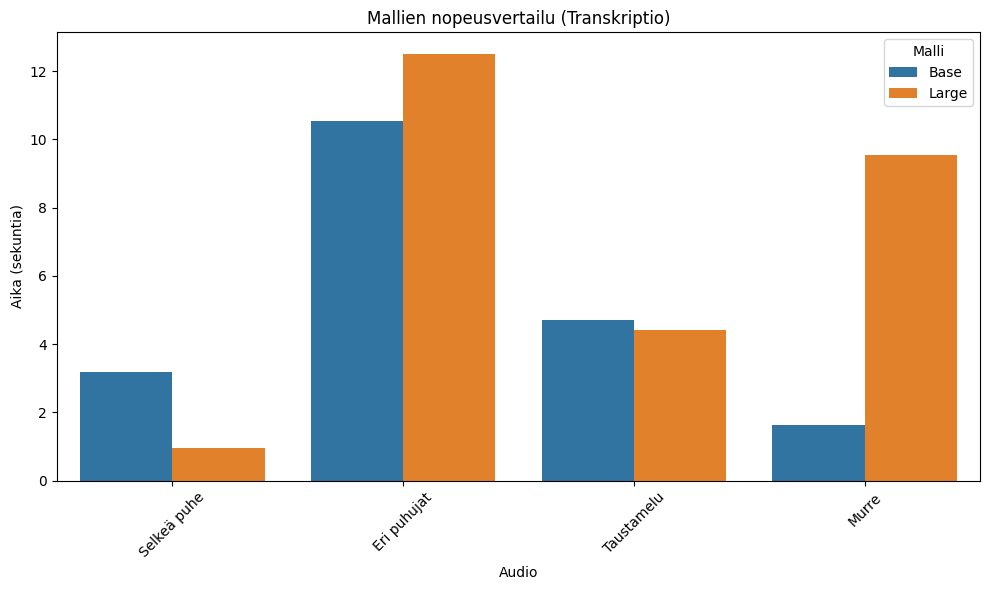

In [4]:
import seaborn as sns

# Luodaan DataFrame tuloksista
df = pd.DataFrame(results_data)

pd.set_option('display.max_colwidth', 100)


plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Audio', y='Aika (Transkriptio) s', hue='Malli')
plt.title('Mallien nopeusvertailu (Transkriptio)')
plt.ylabel('Aika (sekuntia)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Opittu ja Pohdinta

## Analyysi ja Johtopäätökset

### 1. Mallien suorituskyky
* **Tarkkuus:**
Tulokset osoittavat valtavan eron mallien **Base-malli** romahti täysin haastavissa olosuhteissa. "Eri puhujat" ja "Taustamelu" -näytteissä malli joutui tyypilliseen Transformer-arkkitehtuurin virhetilaan eli **toistosilmukkaan** (repetition loop), jossa se generoi samaa tekstiä loputtomiin ("johon silleen tapaa johon silleen..."). Murrenäytteessä Base ei kyennyt tunnistamaan sanoja lainkaan.

* **Large-malli** suoriutui erinomaisesti samoista haasteista. Se tunnisti slangisanat ("shotti", "salmari") ja ymmärsi itämurteista puhetta ("jubailemaan", "Myllypuro") lähes täydellisesti. Taustahäly ei estänyt Large-mallia saamasta selvää puhutusta sisällöstä.

* **Nopeus:** Base-malli oli odotetusti huomattavasti nopeampi, mutta laadun kustannuksella. Kuvaajan ja taulukon perusteella Base oli noin 3–5 kertaa nopeampi kuin Large-malli (esim. Murre-näytteessä 1.7s vs 9.8s ja Eri puhujat -näytteessä 5.5s vs 15.4s).

### 2. Käännöksen laatu
* Whisper kykenee kääntämään suomea englanniksi "lennossa" (`task="translate"`).
* Arvio laadusta: Käännöksen laatu korreloi suoraan mallin koon kanssa.

 **Base-mallin** käännökset olivat hallusinaatioita: kun se ei ymmärtänyt puhetta, se alkoi keksiä englanninkielistä tekstiä, joka ei liittynyt aiheeseen ("...hotel for a long time...") tai toisti samaa sanaa ("bad or bad or bad").

**Large-malli** tuotti erittäin luontevaa ja idiomaattista englantia. Se ei kääntänyt sana sanalta, vaan välitti merkityksen. Esimerkiksi fraasi "Myllypuron pitsaperjantai" kääntyi luontevasti muotoon "pizza on friday in myllipuro". Tämä osoittaa, että malli ymmärtää kontekstin eikä toimi vain sanakirjana.*

### 3. Miksi esikoulutettu Whisper toimii hyvin?
Whisper on koulutettu massiivisella määrällä monikielistä ja monimuotoista dataa. Tulokset vahvistavat tämän teorian käytännössä:

**Kohinansieto:** Large-malli ei häiriintynyt taustahälystä, koska koulutusdatassa on ollut paljon ei-studiotasoista ääntä.

**Kieltenväliset yhteydet:** Vaikka puhuja käytti slangia ("diili", "shotti"), malli osasi kirjoittaa ne oikein, todennäköisesti hyödyntäen englannin kielen tietämystään suomenkielisen foneettisen datan tukena.

**Kontekstin ymmärrys:** Transformer-arkkitehtuurin self-attention-mekanismi auttoi Large-mallia päättelemään epäselvät sanat (kuten murresanat) ympäröivän lauseen perusteella, siinä missä Base-malli putosi kärryiltä heti alussa.

### 4. Transformer-arkkitehtuurin vahvuudet ja rajoitukset
Vahvuudet:

**Skaalautuvuus:** Testi osoitti konkreettisesti "Scaling Laws" -periaatteen: parametrien määrän kasvattaminen (Base -> Large) paransi suorituskykyä radikaalisti, muuttaen käyttökelvottoman tuloksen erinomaiseksi.

**Pitkän kontekstin ymmärrys:** Large-malli pystyi seuraamaan kahden puhujan välistä dialogia ("Okei, okei. Mikä oli diili?") ja pitämään langat käsissään, kun taas pienempi malli hukkasi kontekstin.

## Rajoitukset:

**Resurssisyöppöys:** Large-mallin ajaminen vaati GPU:n käyttöä ollakseen järkevän nopeaa. Prosessorilla (CPU) ajettuna 15 sekunnin käsittelyaika olisi moninkertainen.

**Hallusinaatiot:** Base-mallin tuottama teksti ("See you next time!", "hotel for a long time") tilanteissa, joissa se ei kuullut puhetta, on Transforer-mallien tyypillinen heikkous. Malli pyrkii aina tuottamaan jotain todennäköistä tekstiä, vaikka syöte olisi sille epäselvä.